# CON QUESTE MODIFICHE ALLA TRAINING FUNCTION:

1. Viene settato un seed per il training, quindi eventuali rerun della prima parte potrebbero modificare le performance
2. Viene utilizzata la validation accuracy invece che la validation loss per l'early stopping

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 37 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 43.34 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [2]:
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance
from typing import List, Tuple
import copy
import cv2
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

!pip install torchsummary
from torchsummary import summary
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.4.0
12.3
True


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split # used for splitting the dataset in train and test
        self.paths, self.labels = self.read_file() #reading the labels and images

        self.transform = transform 

    def __len__(self) -> int: #get the number of elements in the dataset
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]: 
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    # legge un file di testo che contiene i percorsi delle immagini e le etichette associate
    # restituisce due liste: una con percorsi delle immagini e una con le etichette
    def read_file(self) -> Tuple[List[str], List[int]]: #outputs a tuple
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ") #rimuove il carattere di nuova linea, e poi divide in 3 parti con virgola come separatore 
                paths.append(path), labels.append(int(label)) #salva solo percorsi ed etichette

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [5]:
mean = [0.5306, 0.3964, 0.2564]
std = [0.2293, 0.2060, 0.1746]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = GroceryStoreDataset(split="train", transform=transform)
test_dataset = GroceryStoreDataset(split="test", transform=transform)
val_dataset = GroceryStoreDataset(split="val", transform=transform)

In [72]:
# Training function
def train_model(seed, model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train() 
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        if epoch_val_acc >= best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(best_loss)
        else:
            scheduler.step()

    print(f'Maximum val accuracy: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [73]:
def restore_initial_setup(seed, train_dataset, test_dataset, val_dataset, device):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    model = models.resnet18(weights='IMAGENET1K_V1')

    # The final layer is modified to have 43 classes as output
    num_classes = 43
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model = model.to(device)

    # loss function
    loss_fn = nn.CrossEntropyLoss()

    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

    # learning rate scheduler
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    batch_size = 32
    num_epochs = 30
    patience = 7

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader

def experiment_runner(n, description, seed, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader):
    # set seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'EXPERIMENT {n}: {description} - using seed = {seed}')
    print('\n')
    # train the model
    model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(seed, model, train_loader, val_loader, num_epochs, patience, optimizer, loss_fn, scheduler)

    print('\n TRAINING AND VALIDATION LOSS VARIATION OVER THE EPOCHS')
    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('\n VALIDATION ACCURACY VARIATION OVER THE EPOCHS')
    # Plot the validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return


In [70]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(42, train_dataset, test_dataset, val_dataset, device)

EXPERIMENT 0: INITIAL SETUP - using seed = 42


Epoch [1/30], Train Loss: 1.4170 Acc: 0.6742 | Val Loss: 1.1248 Acc: 0.7196
Epoch [2/30], Train Loss: 0.2238 Acc: 0.9754 | Val Loss: 0.7893 Acc: 0.7804
Epoch [3/30], Train Loss: 0.0616 Acc: 0.9989 | Val Loss: 0.6838 Acc: 0.8074
Epoch [4/30], Train Loss: 0.0283 Acc: 1.0000 | Val Loss: 0.6860 Acc: 0.8277
Epoch [5/30], Train Loss: 0.0176 Acc: 1.0000 | Val Loss: 0.6447 Acc: 0.8209
Epoch [6/30], Train Loss: 0.0131 Acc: 1.0000 | Val Loss: 0.6120 Acc: 0.8142
Epoch [7/30], Train Loss: 0.0253 Acc: 0.9962 | Val Loss: 0.7629 Acc: 0.7872
Early stopping triggered
Maximum val accuracy: inf

 TRAINING AND VALIDATION LOSS VARIATION OVER THE EPOCHS


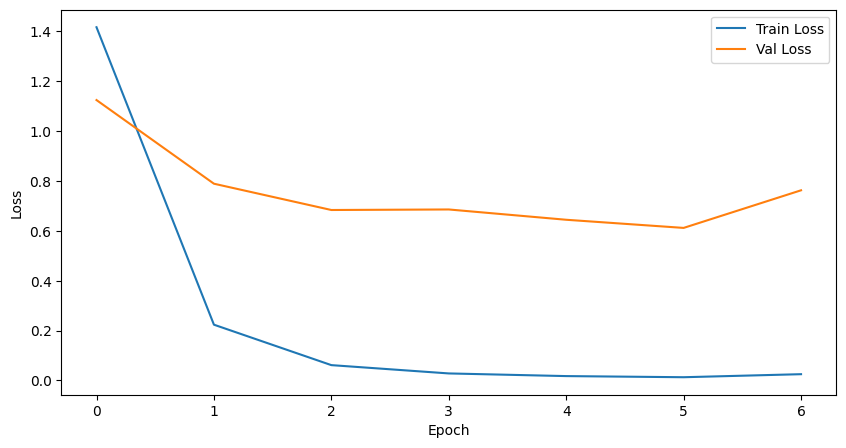


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


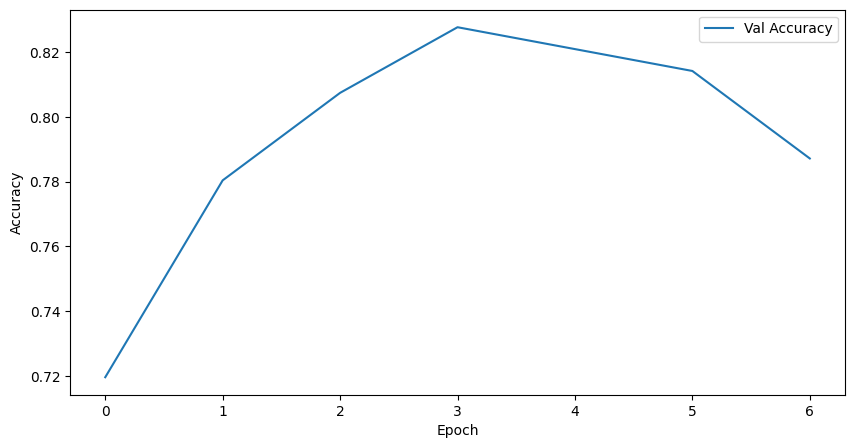

In [71]:
experiment_runner(0, 'INITIAL SETUP', 42, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

In [58]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(42, train_dataset, test_dataset, val_dataset, device)

EXPERIMENT 0: INITIAL SETUP - using seed = 1


Epoch [1/30], Train Loss: 1.4454 Acc: 0.6742 | Val Loss: 1.0931 Acc: 0.6892
Epoch [2/30], Train Loss: 0.2324 Acc: 0.9746 | Val Loss: 0.7094 Acc: 0.8243
Epoch [3/30], Train Loss: 0.0643 Acc: 0.9977 | Val Loss: 0.6179 Acc: 0.8277
Epoch [4/30], Train Loss: 0.0309 Acc: 0.9996 | Val Loss: 0.5777 Acc: 0.8277
Epoch [5/30], Train Loss: 0.0185 Acc: 0.9996 | Val Loss: 0.5831 Acc: 0.8209
Epoch [6/30], Train Loss: 0.0144 Acc: 1.0000 | Val Loss: 0.5146 Acc: 0.8615
Epoch [7/30], Train Loss: 0.0162 Acc: 0.9985 | Val Loss: 0.5552 Acc: 0.8412
Epoch [8/30], Train Loss: 0.0112 Acc: 0.9992 | Val Loss: 0.5545 Acc: 0.8311
Epoch [9/30], Train Loss: 0.0086 Acc: 1.0000 | Val Loss: 0.5172 Acc: 0.8446
Epoch [10/30], Train Loss: 0.0089 Acc: 1.0000 | Val Loss: 0.5371 Acc: 0.8446
Epoch [11/30], Train Loss: 0.0082 Acc: 0.9996 | Val Loss: 0.5422 Acc: 0.8446
Epoch [12/30], Train Loss: 0.0076 Acc: 1.0000 | Val Loss: 0.5253 Acc: 0.8514
Epoch [13/30], Train Loss: 0.0078 Acc:

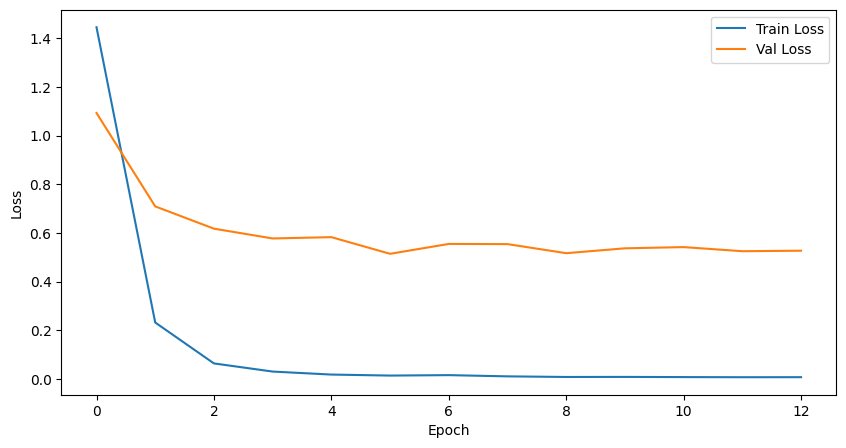


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


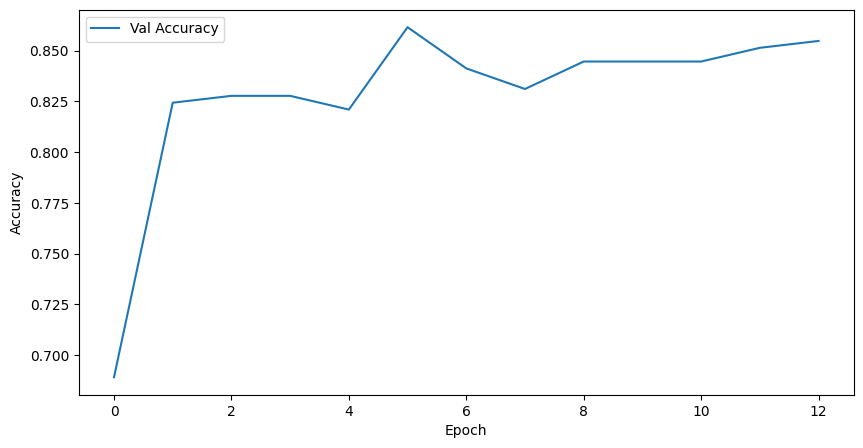

In [59]:
experiment_runner(0, 'INITIAL SETUP', 1, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)

In [62]:
model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader = restore_initial_setup(42, train_dataset, test_dataset, val_dataset, device)

EXPERIMENT 0: INITIAL SETUP - using seed = 125


Epoch [1/30], Train Loss: 1.0539 Acc: 0.7466 | Val Loss: 0.7805 Acc: 0.7973
Epoch [2/30], Train Loss: 0.1181 Acc: 0.9920 | Val Loss: 0.7242 Acc: 0.8176
Epoch [3/30], Train Loss: 0.0892 Acc: 0.9970 | Val Loss: 0.6793 Acc: 0.8209
Epoch [4/30], Train Loss: 0.0748 Acc: 0.9996 | Val Loss: 0.6766 Acc: 0.8209
Epoch [5/30], Train Loss: 0.0640 Acc: 0.9989 | Val Loss: 0.6769 Acc: 0.8041
Epoch [6/30], Train Loss: 0.0521 Acc: 0.9992 | Val Loss: 0.6337 Acc: 0.8074
Epoch [7/30], Train Loss: 0.0455 Acc: 1.0000 | Val Loss: 0.6352 Acc: 0.8277
Epoch [8/30], Train Loss: 0.0423 Acc: 0.9996 | Val Loss: 0.6476 Acc: 0.8176
Epoch [9/30], Train Loss: 0.0368 Acc: 1.0000 | Val Loss: 0.6461 Acc: 0.8277
Epoch [10/30], Train Loss: 0.0369 Acc: 1.0000 | Val Loss: 0.6258 Acc: 0.8277
Epoch [11/30], Train Loss: 0.0374 Acc: 0.9996 | Val Loss: 0.6014 Acc: 0.8209
Epoch [12/30], Train Loss: 0.0373 Acc: 0.9996 | Val Loss: 0.6107 Acc: 0.8345
Epoch [13/30], Train Loss: 0.0355 Ac

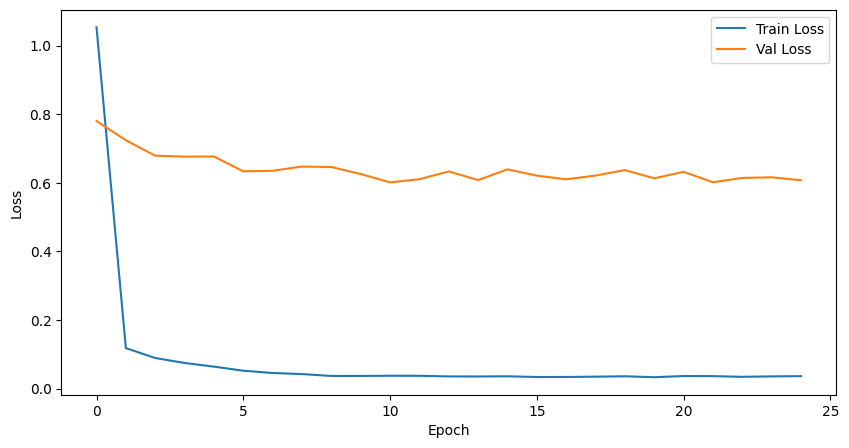


 VALIDATION ACCURACY VARIATION OVER THE EPOCHS


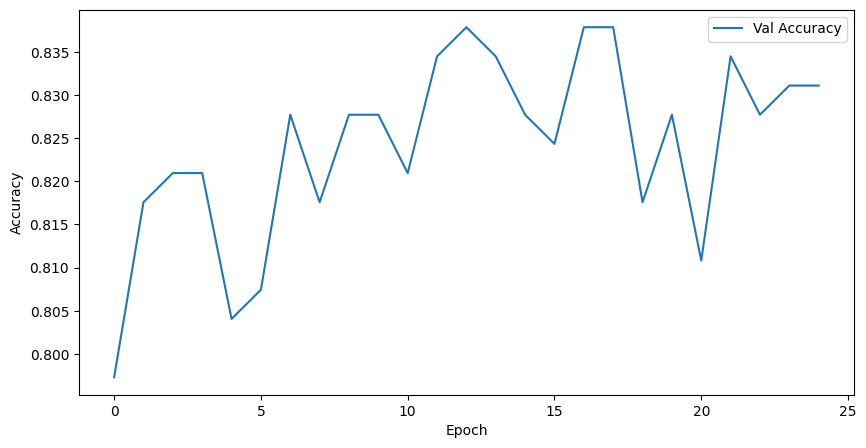

In [74]:
experiment_runner(0, 'INITIAL SETUP', 125, device, model, loss_fn, optimizer, scheduler, batch_size, num_epochs, patience, train_loader, test_loader, val_loader)